20200807_03

Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We would like to compute the aperture correction for HST grism extraction when performing on a drz-blot flt frame.

# Background
Aperture correction for original flt frame of HST grisms was presented in ISRs. However, this correction might not be the same when the reduction is performed on a drz-blot flt frame. Theoretically, we would expect drz-blot flt objects to have different PSFs. Therefore, additional correction should be necessary when performing grism reduction on drz-blot flt frame.

# Previously...
- 20200807_02: G141 of GD153 was analyzed for the drzblot/crcorr aperture correction. Results showed that the correction is negligible when halfdy >= 3.

# Objectives
- Derive drzblot/crcorr aperture correction for G141 with stars S03 and S02 in GRB 190829A, 202011 frame.

# Data
Proposal ID 15510.

# Code
Code primer can be fetched from 20200807_02.
 

In [1]:
from hstgrism.container import Container
from hstgrism.confreader import ConfReader
from hstgrism.computesip import ComputeSIP
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg141 import WFC3IRG141
from hstgrism.cutout2d import Cutout2D
from hstgrism.objectmask import ObjectMask
from hstgrism.flatfield import FlatField
from hstgrism.background import Background
from hstgrism.to_fullframe import to_fullframe
from hstgrism.grismapcorr import GrismApCorr
from hstgrism.show_overview import show_overview
from hstgrism.show_bbox import show_bbox
from hstgrism.show_sum1d import show_sum1d
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import copy,glob


In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt

def show_dither(flist):
    """
    Plot dither pattern for diagnosis
    """
    fig = plt.figure()
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title('dither pattern',fontsize=12)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title('reduced dither pattern',fontsize=12)
    for i,ii in enumerate(flist):
        scale = fits.open(ii)[1].header['IDCSCALE']
        px,py = fits.open(ii)[0].header['POSTARG1']/scale,fits.open(ii)[0].header['POSTARG2']/scale
        ax1.plot(px,py,'s')
        ax1.annotate(i,(px,py),
                     textcoords='offset points',
                     xytext=(0,10),
                     ha='center',
                     fontsize=12,
                     rotation=0.
                    )
        x,y = np.mod(px,1.),np.mod(py,1.)
        ax2.plot(x,y,'s')
        ax2.annotate(i,(x,y),
                     textcoords='offset points',
                     xytext=(0,10),
                     ha='center',
                     fontsize=12,
                     rotation=0.
                    )
    fig.tight_layout()
        

In [3]:
import numpy as np

def read_ds9region(ds9regfile):
    """
    Assume ds9regfile in the format as ds9, and coordinate system as image
    """
    out = {}
    f = open(ds9regfile,'r')
    for i,ii in enumerate(f.readlines()):
        if i < 3:
            continue
        x,y,_ = np.array(ii.split('(')[1].split(')')[0].split(',')).astype(float)
        z = ii.split('{')[1].split('}')[0]
        out[z] = (x,y)
    return out


In [4]:
from hstgrism.container import Container
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg141 import WFC3IRG141
from hstgrism.cutout2d import Cutout2D
from hstgrism.flatfield import FlatField
from hstgrism.show_overview import show_overview
import pandas as pd
import os

def generate_flatfield_flt_g141(saveprefix,savefolder,plotformat,overwrite,
                           xyd,confile,beam,gfile,dfile,
                           flatfile,
                           params_overview
                          ):
    """
    Use hstgrism to make flatfielded grism flt.
    """
    ##########
    # Make Container
    ##########
    container_params = {'saveprefix':saveprefix,
                        'savefolder':savefolder,
                        'plotformat':plotformat,
                        'overwrite':overwrite
                       }
    containerobj = Container(**container_params)
    ##########
    # Compute xyref
    ##########
    xyref_params = {'xyd':xyd,
                    'xydiff':'default',
                    'xyoff':'default',
                    'confile':confile,
                    'beam':beam,
                    'gfile':gfile,
                    'dfile':dfile,
                    'container':containerobj
                   }
    xyrefobj = ComputeXYREF(**xyref_params)
    xyrefobj.compute()
    xyrefobj.save()
    ##########
    # Map trace and wavelength
    ##########
    xyref = xyrefobj.data['xyref']
    grism_params = {'confile':confile,
                    'beam':beam,
                    'xyref':xyref,
                    'container':containerobj
                   }
    grismobj = WFC3IRG141(**grism_params)
    grismobj.compute()
    grismobj.save()
    ##########
    # show_overview
    ##########
    show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
                  objname=containerobj.data['saveprefix'],
                  save=True,
                  container=containerobj,
                  params=params_overview
                 )    
    ##########
    # Make cutout
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    xg = tdata.xh + tdata.xyref[0]
    yg = tdata.yh + tdata.xyref[1]
    halfdy = 20
    tbox = {'xg':xg,'yg':yg,'halfdyup':halfdy,'halfdylow':halfdy}
    bbox={'padxleft': 15, 'padxright': 15, 'padyup': 15, 'padylow': 15}
    image = fits.open(gfile[0])[gfile[1]].data
    do_mask = True
    cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
    cutoutobj.compute(do_mask)
    cutoutobj.save()
    ##########
    # Make flatfield
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    bbcorner = './{0}/{1}_bbcorner.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    bbdata = pd.read_csv(bbcorner)
    flatobj = FlatField(container=containerobj,flatfile=flatfile,xyref=tdata.xyref,dldp=tdata.dldp)
    flatobj.compute()
    flatobj.save(do_cutout=False)
    ##########
    # Make flatfielded flt
    ##########
    string = './{0}/{1}'.format(containerobj.data['savefolder'],gfile[0].split('/')[-1])
    os.system('cp {0} {1}'.format(gfile[0],string))
    gfile_new = (string,1)
    ffile = ('./{0}/{1}_fullflat.fits'.format(containerobj.data['savefolder'],containerobj.data['saveprefix']),1)
    tmp = fits.open(gfile_new[0])
    tmpdata = tmp[gfile_new[1]].data.copy()
    flatdata = fits.open(ffile[0])[ffile[1]].data.copy()
    m = np.isfinite(flatdata)
    tmpdata[m] = tmpdata[m] / flatdata[m]
    tmp[gfile_new[1]].data = tmpdata.copy()
    tmp.writeto(gfile_new[0],overwrite=True)
    print('Update flatfielded {0}'.format(gfile_new[0]))


In [5]:
from astropy.io import fits

def bkgsub(gfile,bfile,container,savesuffix = 'sub'):
    """
    Perform bacgkground subtraction and save as ./savefolder/saveprefix_savesuffix.fits
    - savesuffix = 'sub' by default
    - output = gfile - bfile
    """
    savefolder = container.data['savefolder']
    saveprefix = container.data['saveprefix']
    gdata = fits.open(gfile[0])[gfile[1]].data
    bdata = fits.open(bfile[0])[bfile[1]].data
    sdata = gdata - bdata
    phdu = fits.PrimaryHDU()
    ihdu = fits.ImageHDU()
    hdul = fits.HDUList([phdu,ihdu])
    hdul[1].data = sdata
    string = './{0}/{1}_{2}.fits'.format(savefolder,saveprefix,savesuffix)
    hdul.writeto(string,overwrite=True)
    print('Save {0}'.format(string))
    

In [6]:
from hstgrism.container import Container
from hstgrism.confreader import ConfReader
from hstgrism.computesip import ComputeSIP
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg141 import WFC3IRG141
from hstgrism.cutout2d import Cutout2D
from hstgrism.objectmask import ObjectMask
from hstgrism.flatfield import FlatField
from hstgrism.background import Background
from hstgrism.to_fullframe import to_fullframe
from hstgrism.grismapcorr import GrismApCorr
from hstgrism.show_overview import show_overview
from hstgrism.show_bbox import show_bbox
from hstgrism.show_sum1d import show_sum1d
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import copy,glob
from drizzlepac.astrodrizzle import AstroDrizzle
from drizzlepac import ablot


The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


# 1. Choose object, perform flatfield, generate crcorr and drzblot files

0 idwbk4czq F140W 58817.67793892 False -28.613661 -32.611141 0.1282500028610229
1 idwbk4d0q G141 58817.68238336 False -28.613661 -32.611141 0.1282500028610229
2 idwbk4d6q G141 58817.74899225 False -27.596661 -32.248138 0.1282500028610229
3 idwbk4d2q G141 58817.69121447 False -27.26066 -31.40214 0.1282500028610229
4 idwbk4d8q G141 58817.75782336 False -26.24366 -31.039141 0.1282500028610229
5 idwbk4d3q G141 58817.70004558 False -25.90766 -30.19314 0.1282500028610229
6 idwbk4d9q G141 58817.76665447 False -24.890659 -29.827141 0.1282500028610229


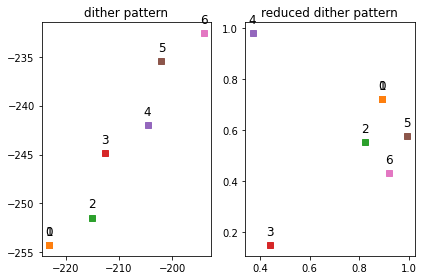

In [12]:
fpath = '/Users/kbhirombhakdi/_work/_data/15510/mastDownload/HST'
tmp = np.array(glob.glob(fpath+'/*k4*/*flt.fits'))
tlist = [tmp[7],tmp[4],tmp[1],tmp[2],tmp[3],tmp[5],tmp[6]]
for ii,i in enumerate(tlist):
    h = fits.open(i)[0].header
    hs = fits.open(i)[1].header
    if h['DATE-OBS'].split('-')[1]!='11':
        continue
    string = '{0} {1} {2} {3} {4} {5} {6} {7}'.format(ii,h['ROOTNAME'],h['FILTER'],h['EXPSTART'],h['SUBARRAY'],
                       h['POSTARG1'],h['POSTARG2'],hs['IDCSCALE']
                      )
    print(string)
show_dither(tlist)
flist = copy.deepcopy(tlist)


{'S01': (213.55011, 706.05741), 'S02': (119.23886, 208.3301), 'S03': (193.81532, 247.72501), 'S04': (678.03785, 267.3912)}


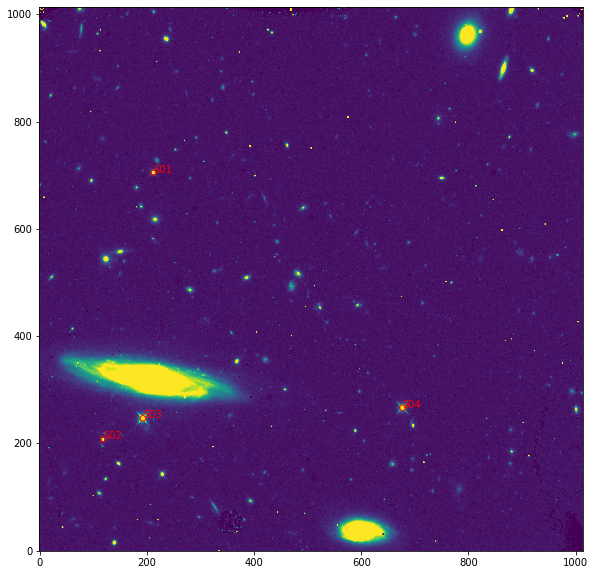

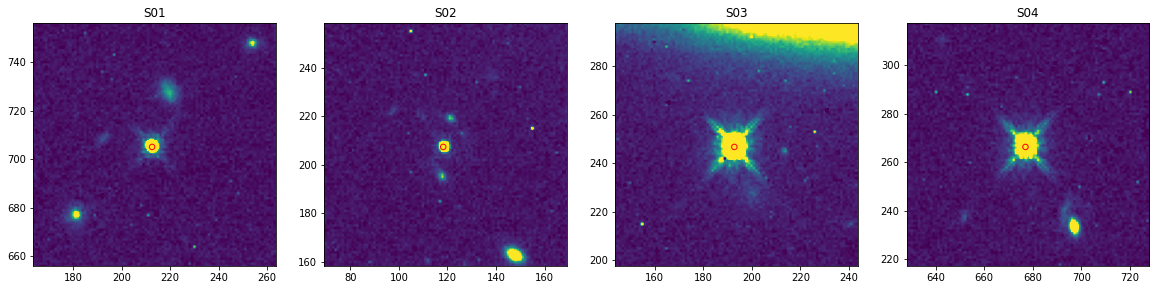

In [13]:
tmp = './ds9.reg'
sourcelist = read_ds9region(tmp)
print(sourcelist)

tmpdata = fits.open(flist[0])[1].data
plt.figure(figsize=(10,10))
m = np.isfinite(tmpdata)
vmin,vmax = np.percentile(tmpdata[m],5.),np.percentile(tmpdata[m],99.)
plt.imshow(tmpdata,origin='lower',cmap='viridis',vmin=vmin,vmax=vmax)

for i in sourcelist:
    x,y = sourcelist[i]
    plt.scatter(x-1,y-1,s=30,edgecolor='red',facecolor='None',label=i)
    plt.annotate(i,(x-1,y-1),fontsize=10,color='red')
    
n = len(sourcelist)
dx,dy = 50,50
fig = plt.figure(figsize=(5*n,5))
for i,ii in enumerate(sourcelist):
    x,y = sourcelist[ii]
    ax = fig.add_subplot(1,n,i+1)
    ax.imshow(tmpdata,origin='lower',cmap='viridis',vmin=vmin,vmax=vmax)
    ax.scatter(x-1,y-1,s=30,edgecolor='red',facecolor='None',label=i)
    ax.set_xlim(x-dx,x+dx)
    ax.set_ylim(y-dy,y+dy)
    ax.set_title(ii,fontsize=12)


In [14]:
sourcename = 'S03'
confile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G141.cal.V4.32/G141.F140W.V4.32.conf'
flatfile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G141.cal.V4.32/WFC3.IR.G141.flat.2.fits'


Save ./idwbk4d0q_S03/idwbk4d0q_S03_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./idwbk4d0q_S03/idwbk4d0q_S03_trace.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_overview.pdf

Save ./idwbk4d0q_S03/idwbk4d0q_S03_tbox.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_bbox.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_bbcorner.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_cutout.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_mask.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_fullflat.fits
Update flatfielded ./idwbk4d0q_S03/idwbk4d0q_flt.fits
Save ./idwbk4d6q_S03/idwbk4d6q_S03_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./idwbk4d6q_S03/idwbk4d6q_S03_trace.csv
Save ./idwbk4d6q_S03/idwbk4d6q_S03_overview.pdf

Save ./idwbk4d6q_S03/idwbk4d6q_S03_tbox.csv
Save ./idwbk4d6q_S03/idwbk4d6q_S03_bbox.csv
Save ./idwbk4d6q_S03/idwbk4d6q_S03_bbcorner.csv

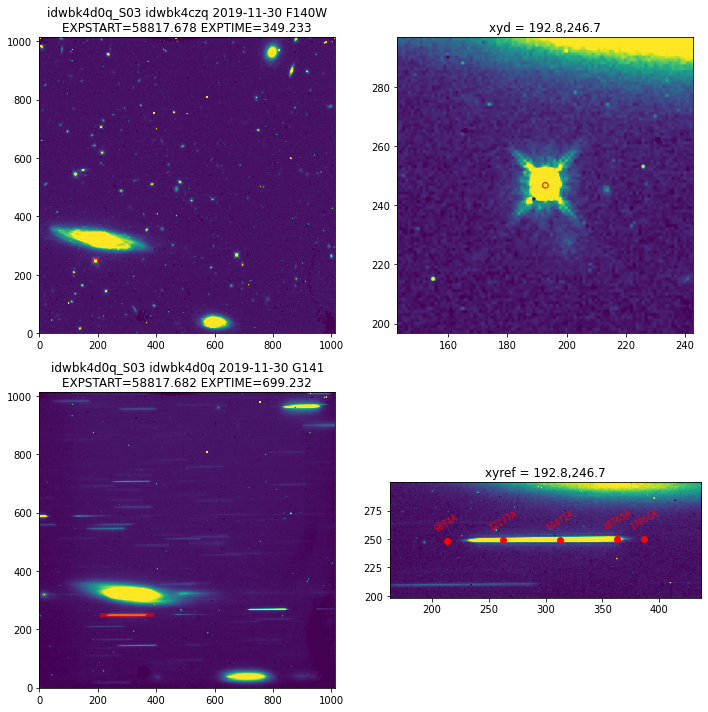

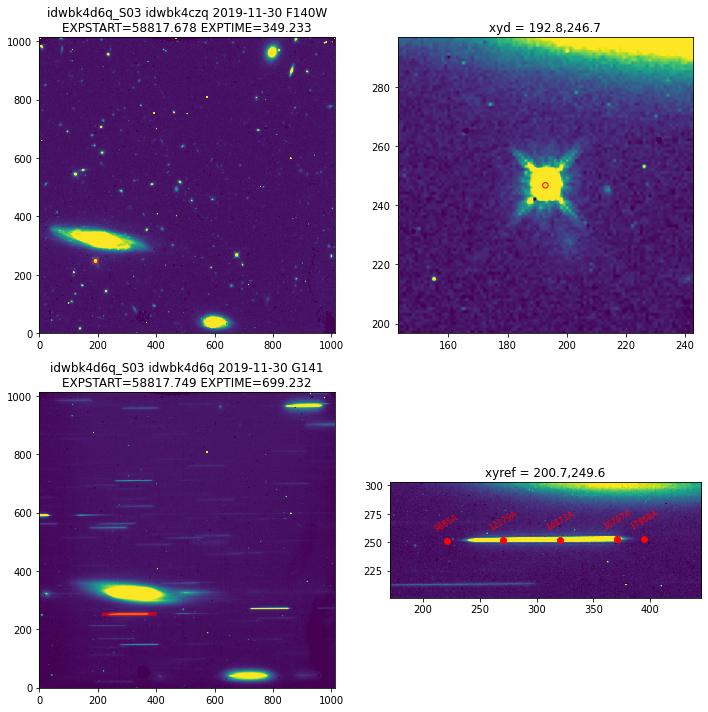

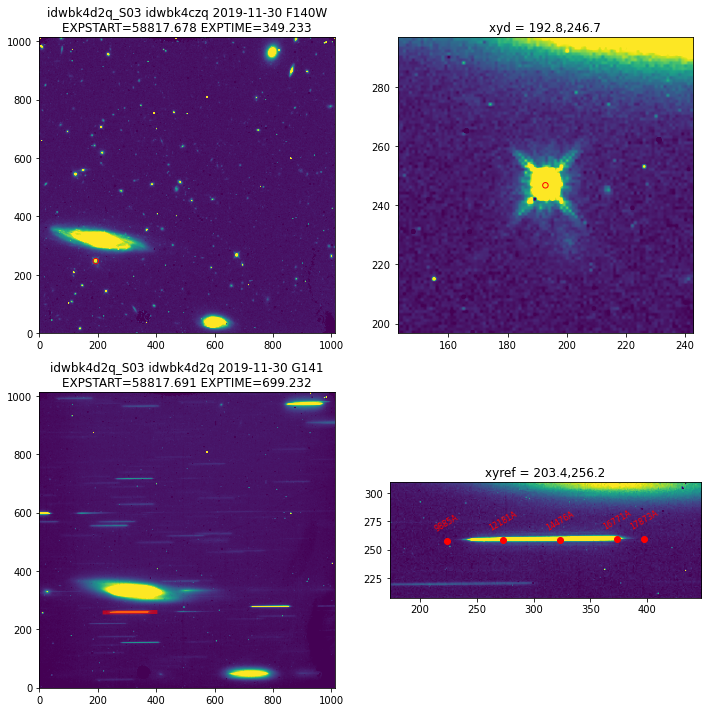

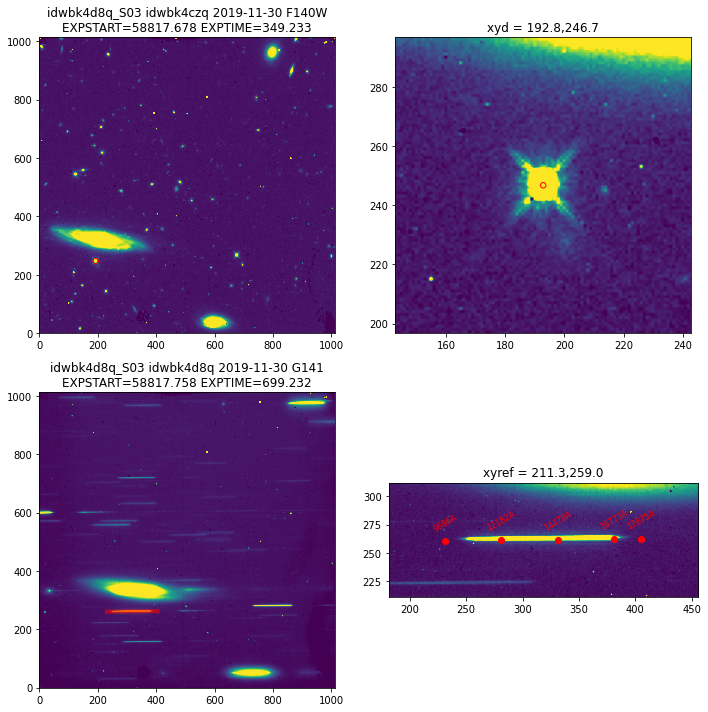

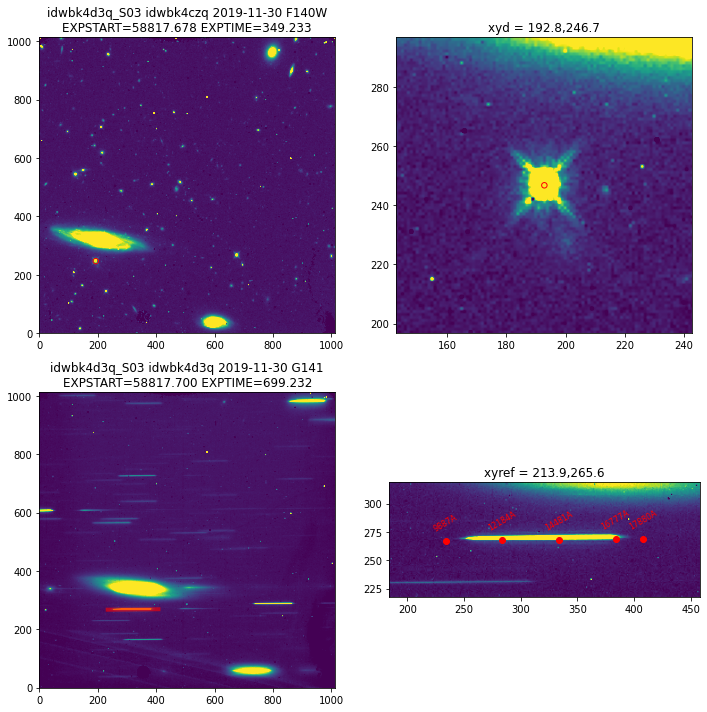

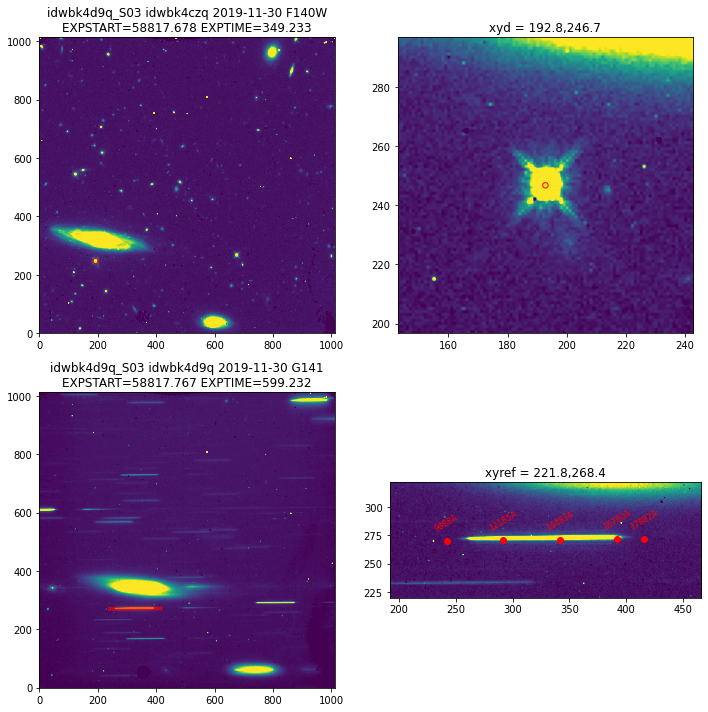

In [15]:
for i,ii in enumerate(flist):
    if i == 0:
        continue
    for j,jj in enumerate(sourcelist):
        if jj != sourcename:
            continue
        dfile = (flist[0],1)
        gfile = (flist[i],1)
        rootname = fits.open(gfile[0])[0].header['ROOTNAME']
        sourcename = jj
        saveprefix = '{0}_{1}'.format(rootname,sourcename)
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        x,y = sourcelist[sourcename]
        xyd = (x-1,y-1)
        beam = 'A'
        params_overview = {'figsize': (10, 10), 
                           '221': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'fontsize': 12, 'title': 'default'}, 
                           '222': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'padxy': (50, 50), 'fontsize': 12, 'title': 'default'}, 
                           '223': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 4, 'alpha': 0.6, 'fontsize': 12, 'title': 'default'}, 
                           '224': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 0, 'alpha': 0.6, 'padxy': (50, 50), 'tickperx': 50, 'annotate_marker': 'ro', 'annotate_color': 'red', 'annotate_fontsize': 8, 'annotate_rotation': 30.0, 'fontsize': 12, 'title': 'default'}}
        generate_flatfield_flt_g141(saveprefix,savefolder,plotformat,overwrite,
                                   xyd,confile,beam,gfile,dfile,
                                   flatfile,
                               params_overview
                                  )


In [16]:
# make drzlist
drzlist = []
for ii,i in enumerate(flist):
    if ii==0:
        continue
    tmp = i.split('/')[-1]
    tmpp = tmp.split('_')[0]
    string = './{0}_{1}/{2}'.format(tmpp,sourcename,tmp)
    drzlist.append(string)
drzlist


['./idwbk4d0q_S03/idwbk4d0q_flt.fits',
 './idwbk4d6q_S03/idwbk4d6q_flt.fits',
 './idwbk4d2q_S03/idwbk4d2q_flt.fits',
 './idwbk4d8q_S03/idwbk4d8q_flt.fits',
 './idwbk4d3q_S03/idwbk4d3q_flt.fits',
 './idwbk4d9q_S03/idwbk4d9q_flt.fits']

In [17]:
# drizzle
params_drz = {'build':True,
          'restore':False,
          'overwrite':False,
          'clean':False,
          # Step 1 Statis Mask
          'static':False,
          # Step 2 Sky Sub
          'skysub':True,
          'skymethod':'localmin',
          'skystat':'median',
          # Step 3 Driz Sep
          'driz_separate':True,
          'driz_sep_kernel':'turbo',
          'driz_sep_pixfrac':1., # Set this high for CR
#           'driz_sep_scale':0.05, # Smaller than native size, better for CR
          # Step 4 Median
          'median':True,
          'combine_type':'median',
          'combine_nhigh':1, # Reject highest values before computing median, good for CR
          # Step 5 Blot
          'blot':True,
          'blot_interp':'poly5',
          'blot_addsky':True,
          # Step 6 CR
          'driz_cr':True,
          'driz_cr_corr':True,
          'driz_cr_ctegrow':0,
          # Step 7 Final Combine
          'driz_combine':True,
              'final_refimage':drzlist[0]
         }
AstroDrizzle(input=drzlist,output=sourcename,**params_drz)


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 13:10:45.769 (07/08/2020)

==== Processing Step  Initialization  started at  13:10:45.772 (07/08/2020)

Creating OUTPUT WCS from ./idwbk4d0q_S03/idwbk4d0q_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.8535098079544e-06 -3.356512942226e-05
CD_21  CD_22: -3.7573026532114e-05 1.54323350039e-06
CRVAL    : 44.535928876384 -8.9662964459753
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542737893509194
ORIENTAT : -87.36754952931935
********************************************************************************
*
*  Estimated memory usage:  up to 117 Mb.
*  Output image size:       1014 X 1014 pixels. 
*  Output image file:       ~ 11 Mb. 
*  Cores available:         6
*
********************************************************************************
==== Processing Step Initialization finished at 13:10:46.812 (07/08/2020)
==== Processing Step  Static Mask  started at  13:10:4

reference sky value for image '/Users/kbhirombhakdi/_work/Sidekicks/20200807/idwbk4d9q_S03/idwbk4d9q_flt.fits' is 659.8978240875525
Saving output median image to: 'S03_med.fits'
==== Processing Step Create Median finished at 13:10:49.628 (07/08/2020)
==== Processing Step  Blot  started at  13:10:49.630 (07/08/2020)

    Blot: creating blotted image:  /Users/kbhirombhakdi/_work/Sidekicks/20200807/idwbk4d0q_S03/idwbk4d0q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /Users/kbhirombhakdi/_work/Sidekicks/20200807/idwbk4d0q_S03/idwbk4d0q_sci1_blt.fits
Writing out image to disk: /Users/kbhirombhakdi/_work/Sidekicks/20200807/idwbk4d0q_S03/idwbk4d0q_sci1_blt.fits
    Blot: creating blotted image:  /Users/kbhirombhakdi/_work/Sidekicks/20200807/idwbk4d6q_S03/idwbk4d6q_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /Users/kbhirombhakdi/_work/Sidekicks/20200807/idwbk4d6q_S03/idwbk4d6q_sci1_blt.

In [22]:
# setup for drzblot
drzfile = glob.glob('{0}_drz.fits'.format(sourcename))[0]
reffile = drzlist[0]
skyval = fits.open(reffile)[1].header['MDRIZSKY']
rootname,sourcename = reffile.split('/')[1].split('_')
outdata = './drzblot_{0}/{1}_drzblot_sci.fits'.format(sourcename,rootname)
drzfile,reffile,skyval,outdata

('S03_drz.fits',
 './idwbk4d0q_S03/idwbk4d0q_flt.fits',
 1.12198805809021,
 './drzblot_S03/idwbk4d0q_drzblot_sci.fits')

In [23]:
# facilitate creating folder
saveprefix = rootname
savefolder = 'drzblot_{0}'.format(sourcename)
plotformat = 'pdf'
overwrite = False
containter_drzblot = Container(saveprefix,savefolder,plotformat,overwrite)
# blot
ablot.blot('{0}[1]'.format(drzfile),'{0}[1]'.format(reffile),addsky=False,skyval=skyval,
           outdata=outdata,in_units='counts',out_units='cps')
# replace back
os.system('cp {0} ./{1}/'.format(flist[1],savefolder))
string = './{0}/{1}'.format(savefolder,flist[1].split('/')[-1])
tmp = fits.open(string)
tmpp = fits.open(outdata)
tmp[1].data = tmpp[1].data.copy()
tmp.writeto(string,overwrite=True)


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder drzblot_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Using coordinate transformation defined by user...
Added 1.12198805809021 counts back in to blotted image as sky.
Created output image: ./drzblot_S03/idwbk4d0q_drzblot_sci.fits


# 2. Extract drzblot

In [24]:
halfdy = np.array([0,1,2,3,4,5,6,7])

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder drzblot_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./drzblot_S03/drzblot_S03_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./drzblot_S03/drzblot_S03_trace.csv
Save ./drzblot_S03/drzblot_S03_tbox.csv
Save ./drzblot_S03/drzblot_S03_bbox.csv
Save ./drzblot_S03/drzblot_S03_bbcorner.csv
Save ./drzblot_S03/drzblot_S03_cutout.fits
Save ./drzblot_S03/drzblot_S03_mask.fits
Save ./drzblot_S03/drzblot_S03_overview.pdf



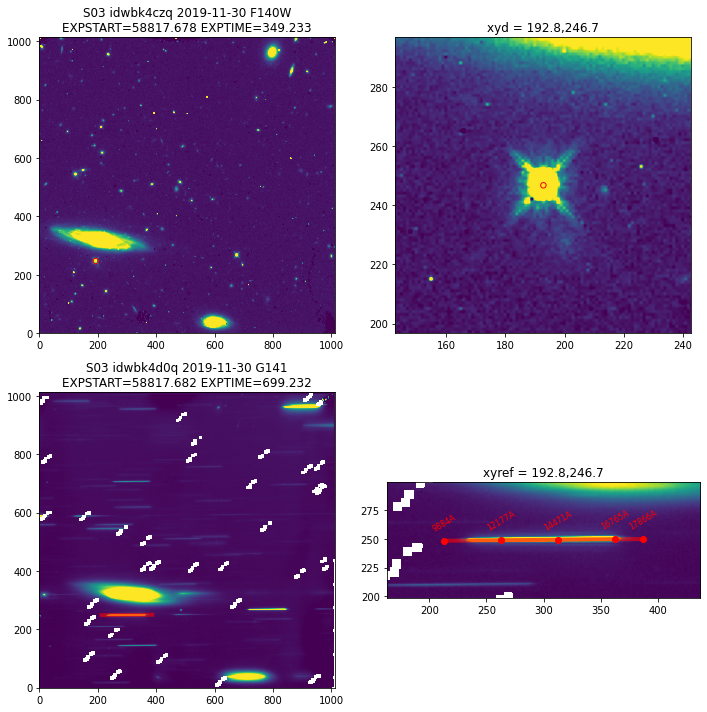

In [25]:
gfile = ('./drzblot_{0}/{1}_flt.fits'.format(sourcename,flist[1].split('/')[-1].split('_')[0]),1)
beam = 'A'
dfile = (flist[0],1)
x,y = sourcelist[sourcename]
xyd = (x-1,y-1)

saveprefix = 'drzblot_{0}'.format(sourcename)
savefolder = saveprefix
plotformat = 'pdf'
overwrite = False
container_params = {'saveprefix':saveprefix,
                    'savefolder':savefolder,
                    'plotformat':plotformat,
                    'overwrite':overwrite
                   }
containerobj = Container(**container_params)

##########
# Compute xyref
##########
xyref_params = {'xyd':xyd,
                'xydiff':'default',
                'xyoff':'default',
                'confile':confile,
                'beam':beam,
                'gfile':gfile,
                'dfile':dfile,
                'container':containerobj
               }
xyrefobj = ComputeXYREF(**xyref_params)
xyrefobj.compute()
xyrefobj.save()
##########
# Map trace and wavelength
##########
xyref = xyrefobj.data['xyref']
grism_params = {'confile':confile,
                'beam':beam,
                'xyref':xyref,
                'container':containerobj
               }
grismobj = WFC3IRG141(**grism_params)
grismobj.compute()
grismobj.save()
##########
# Make cutout
##########
tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
tdata = pd.read_csv(tfile)
xg = tdata.xh + tdata.xyref[0]
yg = tdata.yh + tdata.xyref[1]
hdy = halfdy.max()
tbox = {'xg':xg,'yg':yg,'halfdyup':hdy,'halfdylow':hdy}
bbox={'padxleft': 5, 'padxright': 5, 'padyup': 5, 'padylow': 5}
image = fits.open(gfile[0])[gfile[1]].data
do_mask = True
cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
cutoutobj.compute(do_mask)
cutoutobj.save()
##########
# show_overview
##########
show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
              objname=sourcename,
              save=True,
              container=containerobj,
             )


Save ./drzblot_S03/drzblot_S03_bbox.pdf


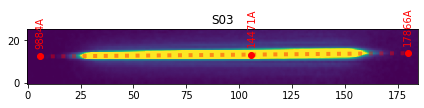

In [26]:
##########
# show_bbox
##########
show_bbox(cutoutdata=cutoutobj.cutout,
          objname=sourcename,
#           maskdata=cutoutobj.mask,
          maskdata=None,
          do_trace=True,
          xcut=xg - cutoutobj.bbcorner['bb0x'],
          ycut=yg - cutoutobj.bbcorner['bb0y'],
          ww=tdata.ww,
          save=True,container=containerobj
         )


Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,184.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,25.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (1.0645774602890015,17.09087562561035) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./drzblot_S03/drzblot_S03_cutbkg.fits
Save ./drzblot_S03/drzblot_S03_maskfit.fits
Save ./drzblot_S03/drzblot_S03_sub.fits


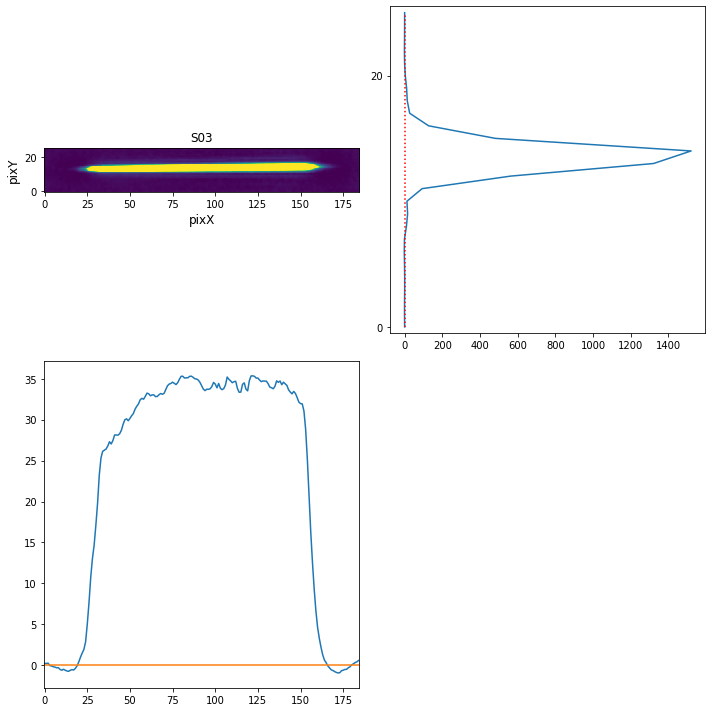

In [30]:
##########
# Background estimation
##########
sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
mfile = ('./{0}/{1}_mask.fits'.format(sfolder,sprefix),1)
gdata = fits.open(gfile[0])[gfile[1]].data
mdata = fits.open(mfile[0])[mfile[1]].data.astype(bool)
norder = 4
sigclip=(False, 5, 1.)
bkgobj = Background(gdata=gdata,norder=norder,mdata=mdata,sigclip=sigclip,container=containerobj)
bkgobj.poly2d.fit()
bkgobj.save(do_yfit=True,do_maskfit=True)
##########
# bkg sub
##########
sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
bfile = ('./{0}/{1}_cutbkg.fits'.format(sfolder,sprefix),1)
bkgsub(gfile,bfile,containerobj)
##########
# show_sum1d
##########
sfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
tmpdata = fits.open(sfile[0])[sfile[1]].data
show_sum1d(gdata=tmpdata,objname=sourcename,mdata=None,do_zero=True,save=False,container=None)


Save ./drzblot_S03/drzblot_S03_halfdy0_mask.fits
Save ./drzblot_S03/drzblot_S03_halfdy1_mask.fits
Save ./drzblot_S03/drzblot_S03_halfdy2_mask.fits
Save ./drzblot_S03/drzblot_S03_halfdy3_mask.fits
Save ./drzblot_S03/drzblot_S03_halfdy4_mask.fits
Save ./drzblot_S03/drzblot_S03_halfdy5_mask.fits
Save ./drzblot_S03/drzblot_S03_halfdy6_mask.fits
Save ./drzblot_S03/drzblot_S03_halfdy7_mask.fits
Save ./drzblot_S03/drzblot_S03_halfdy0_cps.csv
Save ./drzblot_S03/drzblot_S03_halfdy1_cps.csv
Save ./drzblot_S03/drzblot_S03_halfdy2_cps.csv
Save ./drzblot_S03/drzblot_S03_halfdy3_cps.csv
Save ./drzblot_S03/drzblot_S03_halfdy4_cps.csv
Save ./drzblot_S03/drzblot_S03_halfdy5_cps.csv
Save ./drzblot_S03/drzblot_S03_halfdy6_cps.csv
Save ./drzblot_S03/drzblot_S03_halfdy7_cps.csv


Text(0.5, 1.0, 'drzblot')

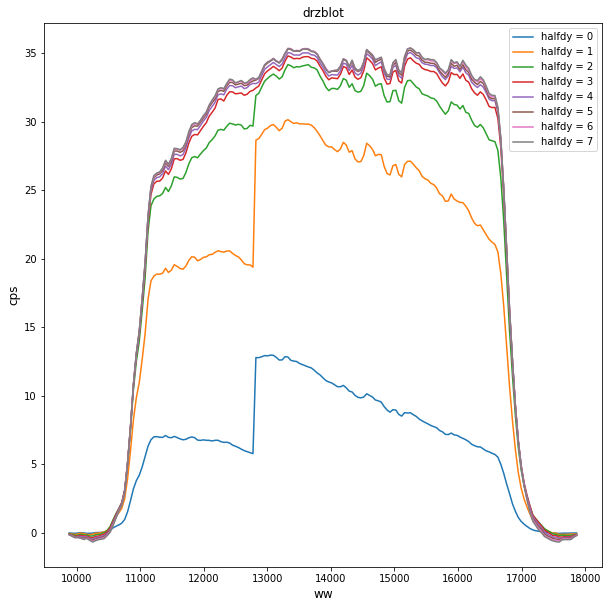

In [31]:
##########
# make mask
##########
sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
gfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
gdata = fits.open(gfile[0])[gfile[1]]
ny,nx = gdata.shape
trace = './{0}/{1}_trace.csv'.format(sfolder,sprefix)
trace = pd.read_csv(trace)
bbcorner = './{0}/{1}_bbcorner.csv'.format(sfolder,sprefix)
bbcorner = pd.read_csv(bbcorner)
tx = trace.xh + trace.xyref[0] - bbcorner.bb0x[0] 
ty = trace.yh + trace.xyref[1] - bbcorner.bb0y[0]
for i,ii in enumerate(halfdy):
    t = ObjectMask(nx,ny,tx,ty,halfdy[i],halfdy[i])
    t.compute()
    tmpcont = copy.deepcopy(containerobj)
    tmpcont.data['saveprefix'] += '_halfdy{0}'.format(halfdy[i])
    t.save(tmpcont)
#     plt.figure(),plt.imshow(t.mask,origin='lower')

##########
# Extraction
##########
for i,ii in enumerate(halfdy):
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    gfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
    mfile = ('./{0}/{1}_halfdy{2}_mask.fits'.format(sfolder,sprefix,halfdy[i]),1)
    bbox = pd.read_csv('./{0}/{1}_bbox.csv'.format(sfolder,sprefix))
    trace = pd.read_csv('./{0}/{1}_trace.csv'.format(sfolder,sprefix))
    tbox = pd.read_csv('./{0}/{1}_tbox.csv'.format(sfolder,sprefix))
    instrument = 'HST-WFC3-IR-G141'
    ww = trace.ww.values
    xh = trace.xh.values
    cps = fits.open(gfile[0])[gfile[1]].data
    cps *= fits.open(mfile[0])[mfile[1]].data
    cps = np.nansum(cps,axis=0)[bbox.padxleft[0]:-bbox.padxright[0]]
    output = {'ww':ww,'cps':cps}
    string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
    pd.DataFrame(output).to_csv(string)
    print('Save {0}'.format(string))
    
##########
# show_cps
##########
plt.figure(figsize=(10,10))
for i,ii in enumerate(halfdy):
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
    t = pd.read_csv(string)
    plt.plot(t.ww,t.cps,label='halfdy = {0}'.format(halfdy[i]))
plt.legend()
plt.xlabel('ww',fontsize=12)
plt.ylabel('cps',fontsize=12)
plt.title('drzblot',fontsize=12)

    

# 3. Extract crcorr

In [32]:
crcorrfile = glob.glob('./*q_{0}/*crclean.fits'.format(sourcename))
crcorrfile

['./idwbk4d0q_S03/idwbk4d0q_crclean.fits',
 './idwbk4d6q_S03/idwbk4d6q_crclean.fits',
 './idwbk4d8q_S03/idwbk4d8q_crclean.fits',
 './idwbk4d9q_S03/idwbk4d9q_crclean.fits',
 './idwbk4d2q_S03/idwbk4d2q_crclean.fits',
 './idwbk4d3q_S03/idwbk4d3q_crclean.fits']

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d0q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./idwbk4d0q_S03/idwbk4d0q_S03_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./idwbk4d0q_S03/idwbk4d0q_S03_trace.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_tbox.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_bbox.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_bbcorner.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_cutout.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_mask.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_overview.pdf

Save ./idwbk4d6q_S03/idwbk4d6q_S03_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./idwbk4d6q_S03/idwbk4d6q_S03_trace.csv
Save ./idwbk4d6q_S03/idwbk4d6q_S03_tbox.csv
Save ./idwbk4d6q_S03/idwbk4d6q_S03_bbox.csv
Save ./idwbk4d6q_S03/idwbk4d6q_S03_bbcorner.csv
Save ./idwbk4d6q_S03/idwbk4d6q_S03_cutout.fits
Save ./idwbk4d6q_S03/idwbk4d6q_S03_mask.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d6q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./idwbk4d6q_S03/idwbk4d6q_S03_overview.pdf

Save ./idwbk4d8q_S03/idwbk4d8q_S03_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./idwbk4d8q_S03/idwbk4d8q_S03_trace.csv
Save ./idwbk4d8q_S03/idwbk4d8q_S03_tbox.csv
Save ./idwbk4d8q_S03/idwbk4d8q_S03_bbox.csv
Save ./idwbk4d8q_S03/idwbk4d8q_S03_bbcorner.csv
Save ./idwbk4d8q_S03/idwbk4d8q_S03_cutout.fits
Save ./idwbk4d8q_S03/idwbk4d8q_S03_mask.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d8q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./idwbk4d8q_S03/idwbk4d8q_S03_overview.pdf

Save ./idwbk4d9q_S03/idwbk4d9q_S03_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./idwbk4d9q_S03/idwbk4d9q_S03_trace.csv
Save ./idwbk4d9q_S03/idwbk4d9q_S03_tbox.csv
Save ./idwbk4d9q_S03/idwbk4d9q_S03_bbox.csv
Save ./idwbk4d9q_S03/idwbk4d9q_S03_bbcorner.csv
Save ./idwbk4d9q_S03/idwbk4d9q_S03_cutout.fits
Save ./idwbk4d9q_S03/idwbk4d9q_S03_mask.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d9q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./idwbk4d9q_S03/idwbk4d9q_S03_overview.pdf

Save ./idwbk4d2q_S03/idwbk4d2q_S03_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./idwbk4d2q_S03/idwbk4d2q_S03_trace.csv
Save ./idwbk4d2q_S03/idwbk4d2q_S03_tbox.csv
Save ./idwbk4d2q_S03/idwbk4d2q_S03_bbox.csv
Save ./idwbk4d2q_S03/idwbk4d2q_S03_bbcorner.csv
Save ./idwbk4d2q_S03/idwbk4d2q_S03_cutout.fits
Save ./idwbk4d2q_S03/idwbk4d2q_S03_mask.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d2q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./idwbk4d2q_S03/idwbk4d2q_S03_overview.pdf

Save ./idwbk4d3q_S03/idwbk4d3q_S03_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./idwbk4d3q_S03/idwbk4d3q_S03_trace.csv
Save ./idwbk4d3q_S03/idwbk4d3q_S03_tbox.csv
Save ./idwbk4d3q_S03/idwbk4d3q_S03_bbox.csv
Save ./idwbk4d3q_S03/idwbk4d3q_S03_bbcorner.csv
Save ./idwbk4d3q_S03/idwbk4d3q_S03_cutout.fits
Save ./idwbk4d3q_S03/idwbk4d3q_S03_mask.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d3q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./idwbk4d3q_S03/idwbk4d3q_S03_overview.pdf



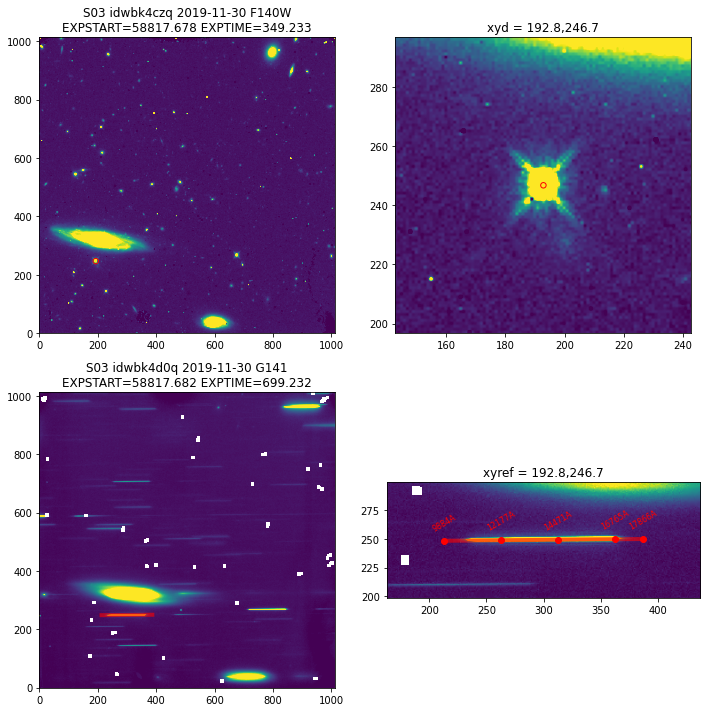

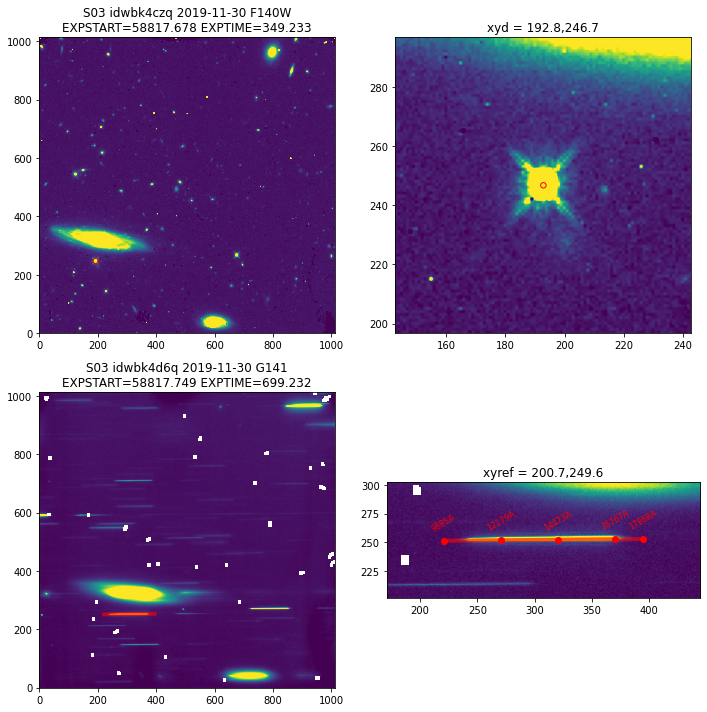

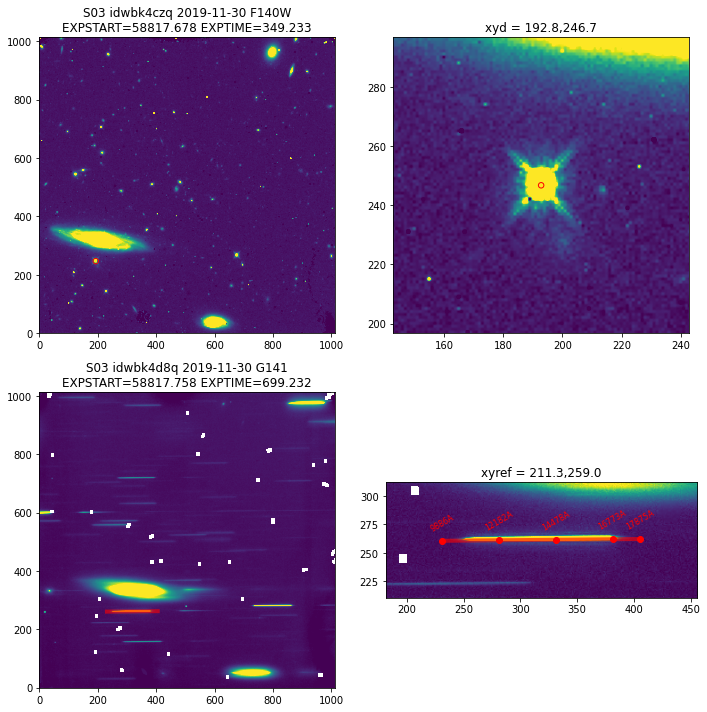

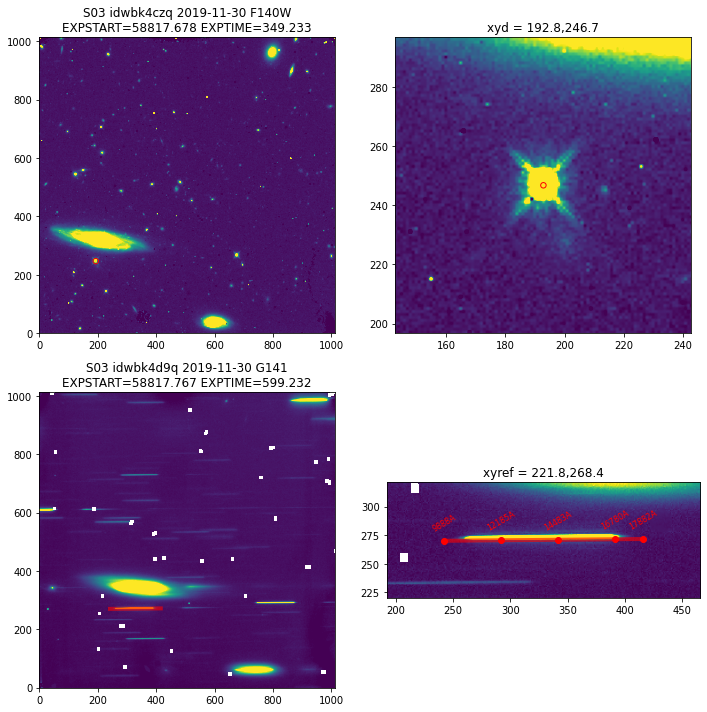

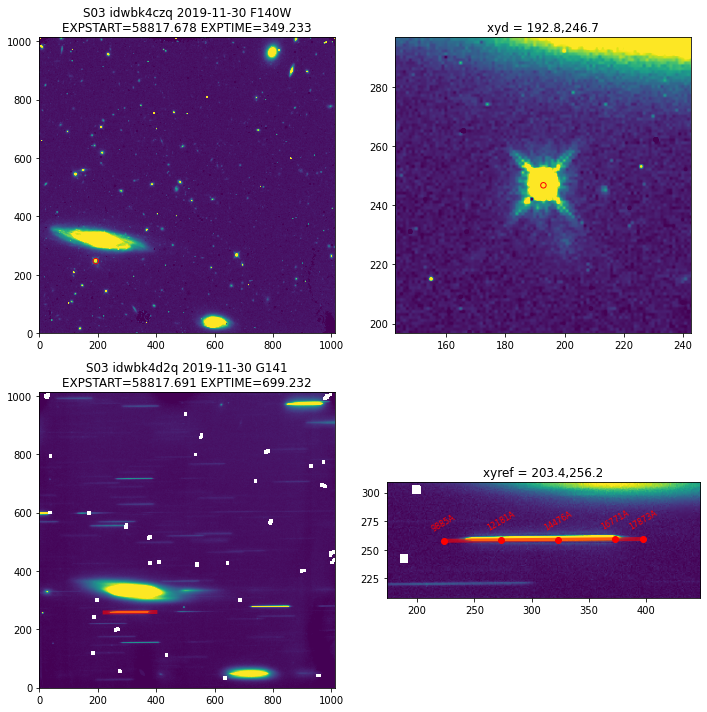

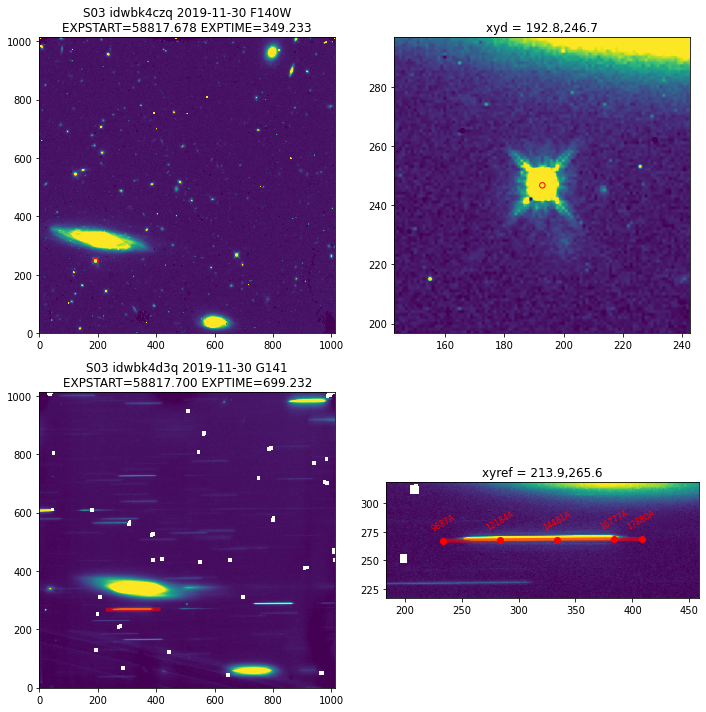

In [33]:
for i,ii in enumerate(crcorrfile):
    gfile = (crcorrfile[i],1)
    beam = 'A'
    x,y = sourcelist[sourcename]
    xyd = (x-1,y-1)

    saveprefix = '{0}_{1}'.format(crcorrfile[i].split('/')[-1].split('_')[0],sourcename)
    savefolder = saveprefix
    plotformat = 'pdf'
    overwrite = False
    container_params = {'saveprefix':saveprefix,
                        'savefolder':savefolder,
                        'plotformat':plotformat,
                        'overwrite':overwrite
                       }
    containerobj = Container(**container_params)

    ##########
    # Compute xyref
    ##########
    xyref_params = {'xyd':xyd,
                    'xydiff':'default',
                    'xyoff':'default',
                    'confile':confile,
                    'beam':beam,
                    'gfile':gfile,
                    'dfile':dfile,
                    'container':containerobj
                   }
    xyrefobj = ComputeXYREF(**xyref_params)
    xyrefobj.compute()
    xyrefobj.save()
    ##########
    # Map trace and wavelength
    ##########
    xyref = xyrefobj.data['xyref']
    grism_params = {'confile':confile,
                    'beam':beam,
                    'xyref':xyref,
                    'container':containerobj
                   }
    grismobj = WFC3IRG141(**grism_params)
    grismobj.compute()
    grismobj.save()
    ##########
    # Make cutout
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    xg = tdata.xh + tdata.xyref[0]
    yg = tdata.yh + tdata.xyref[1]
    hdy = halfdy.max()
    tbox = {'xg':xg,'yg':yg,'halfdyup':hdy,'halfdylow':hdy}
    bbox={'padxleft': 5, 'padxright': 5, 'padyup': 5, 'padylow': 5}
    image = fits.open(gfile[0])[gfile[1]].data
    do_mask = True
    cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
    cutoutobj.compute(do_mask)
    cutoutobj.save()
    ##########
    # show_overview
    ##########
    show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
                  objname=sourcename,
                  save=True,
                  container=containerobj,
                 )


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d0q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d6q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,184.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,25.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.9370968341827393,18.557432174682617) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./idwbk4d0q_S03/idwbk4d0q_S03_cutbkg.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_maskfit.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_sub.fits
Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,184.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,25.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.992646336555481,19.09388542175293) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit
Perform compute
Sigma clipping = False
Save ./idwbk4d6q_S03/idwbk4

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d8q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Perform compute
Sigma clipping = False
Save ./idwbk4d8q_S03/idwbk4d8q_S03_cutbkg.fits
Save ./idwbk4d8q_S03/idwbk4d8q_S03_maskfit.fits
Save ./idwbk4d8q_S03/idwbk4d8q_S03_sub.fits
Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,184.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,25.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.9439018964767456,20.346172332763672) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d9q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Perform compute
Sigma clipping = False
Save ./idwbk4d9q_S03/idwbk4d9q_S03_cutbkg.fits
Save ./idwbk4d9q_S03/idwbk4d9q_S03_maskfit.fits
Save ./idwbk4d9q_S03/idwbk4d9q_S03_sub.fits
Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,184.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,26.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.9001255631446838,19.31229591369629) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d2q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Perform compute
Sigma clipping = False
Save ./idwbk4d2q_S03/idwbk4d2q_S03_cutbkg.fits
Save ./idwbk4d2q_S03/idwbk4d2q_S03_maskfit.fits
Save ./idwbk4d2q_S03/idwbk4d2q_S03_sub.fits
Rescale = True

Exclude 0 invalid data points
data_minmax = (0.0,184.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.0,25.0) : scale_minmax = (-1.0,1.0) : method = linear

Exclude 0 invalid data points
data_minmax = (0.9655813574790955,20.06809425354004) : scale_minmax = (-1.0,1.0) : method = linear
Rescale = False
Perform fit


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d3q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Perform compute
Sigma clipping = False
Save ./idwbk4d3q_S03/idwbk4d3q_S03_cutbkg.fits
Save ./idwbk4d3q_S03/idwbk4d3q_S03_maskfit.fits
Save ./idwbk4d3q_S03/idwbk4d3q_S03_sub.fits


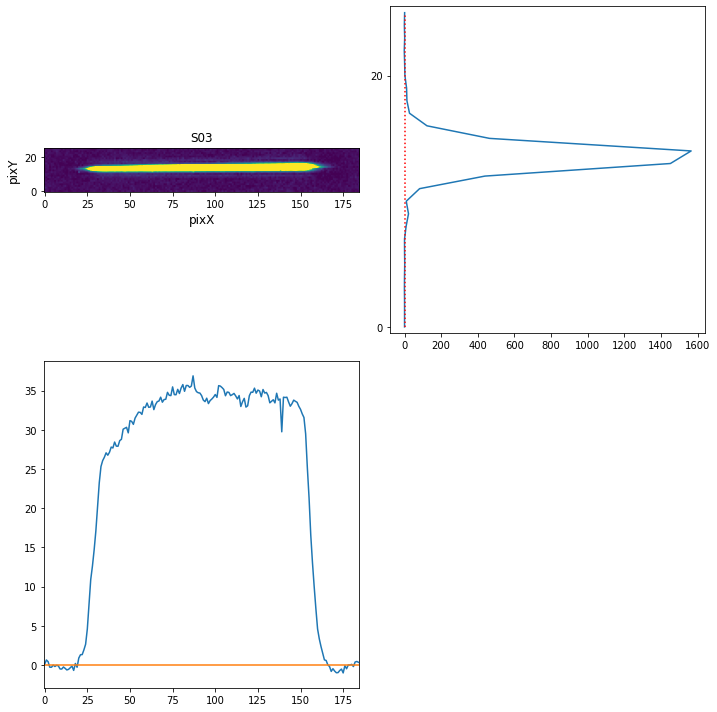

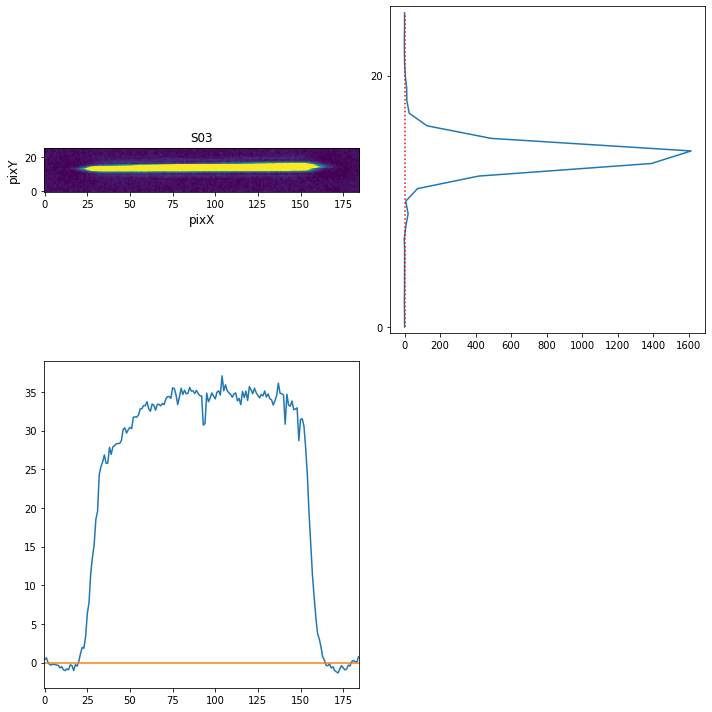

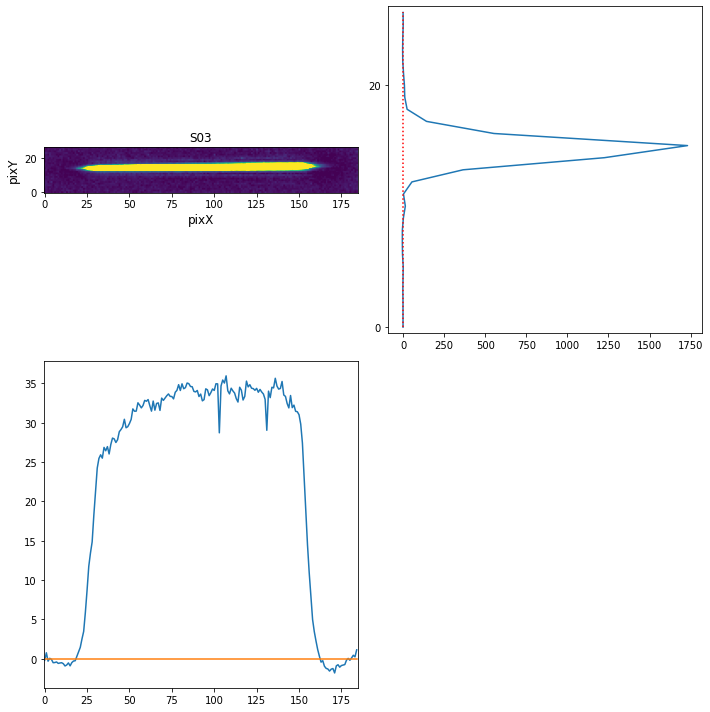

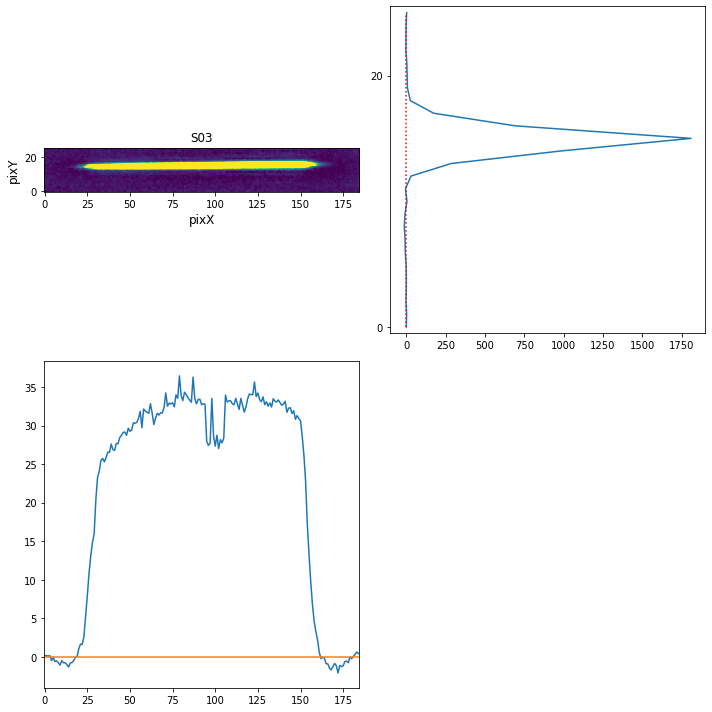

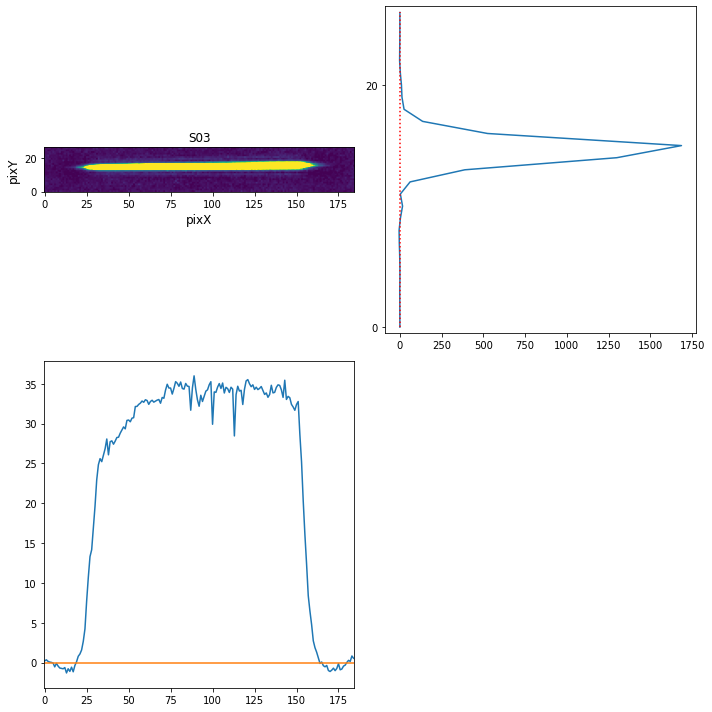

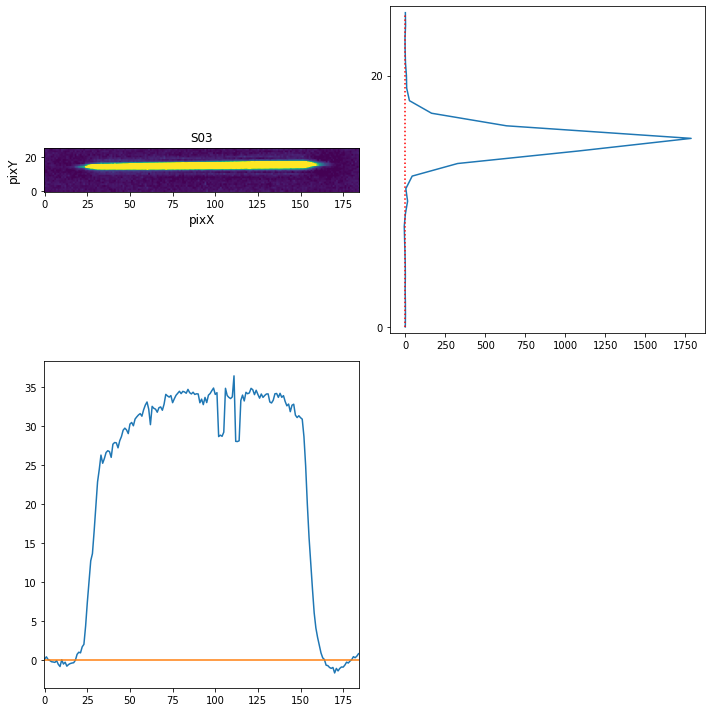

In [34]:
##########
# Background estimation
##########
for i,ii in enumerate(crcorrfile):
    saveprefix = '{0}_{1}'.format(crcorrfile[i].split('/')[-1].split('_')[0],sourcename)
    savefolder = saveprefix
    plotformat = 'pdf'
    overwrite = False
    containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
    mfile = ('./{0}/{1}_mask.fits'.format(sfolder,sprefix),1)
    gdata = fits.open(gfile[0])[gfile[1]].data
    mdata = fits.open(mfile[0])[mfile[1]].data.astype(bool)
    norder = 4
    sigclip=(False, 5, 1.)
    bkgobj = Background(gdata=gdata,norder=norder,mdata=mdata,sigclip=sigclip,container=containerobj)
    bkgobj.poly2d.fit()
    bkgobj.save(do_yfit=True,do_maskfit=True)
    ##########
    # bkg sub
    ##########
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    gfile = ('./{0}/{1}_cutout.fits'.format(sfolder,sprefix),1)
    bfile = ('./{0}/{1}_cutbkg.fits'.format(sfolder,sprefix),1)
    bkgsub(gfile,bfile,containerobj)
    ##########
    # show_sum1d
    ##########
    sfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
    tmpdata = fits.open(sfile[0])[sfile[1]].data
    show_sum1d(gdata=tmpdata,objname=sourcename,mdata=None,do_zero=True,save=False,container=None)


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d0q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d6q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d8q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy0_mask.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy1_mask.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy2_mask.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy3_mask.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy4_mask.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy5_mask.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy6_mask.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy7_mask.fits
Save ./idwbk4d6q_S03/idwbk4d6q_S03_halfdy0_mask.fits
Save ./idwbk4d6q_S03/idwbk4d6q_S03_halfdy1_mask.fits
Save ./idwbk4d6q_S03/idwbk4d6q_S03_halfdy2_mask.fits
Save ./idwbk4d6q_S03/idwbk4d6q_S03_halfdy3_mask.fits
Save ./idwbk4d6q_S03/idwbk4d6q_S03_halfdy4_mask.fits
Save ./idwbk4d6q_S03/idwbk4d6q_S03_halfdy5_mask.fits
Save ./idwbk4d6q_S03/idwbk4d6q_S03_halfdy6_mask.fits
Save ./idwbk4d6q_S03/idwbk4d6q_S03_halfdy7_mask.fits
Save ./idwbk4d8q_S03/idwbk4d8q_S03_halfdy0_mask.fits
Save ./idwbk4d8q_S03/idwbk4d8q_S03_halfdy1_mask.fits
Save ./idwbk4d8q_S03/idwbk4d8q_S03_halfdy2_mas

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d9q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d2q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d3q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)


Save ./idwbk4d3q_S03/idwbk4d3q_S03_halfdy2_mask.fits
Save ./idwbk4d3q_S03/idwbk4d3q_S03_halfdy3_mask.fits
Save ./idwbk4d3q_S03/idwbk4d3q_S03_halfdy4_mask.fits
Save ./idwbk4d3q_S03/idwbk4d3q_S03_halfdy5_mask.fits
Save ./idwbk4d3q_S03/idwbk4d3q_S03_halfdy6_mask.fits
Save ./idwbk4d3q_S03/idwbk4d3q_S03_halfdy7_mask.fits
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy0_cps.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy1_cps.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy2_cps.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy3_cps.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy4_cps.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy5_cps.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy6_cps.csv
Save ./idwbk4d0q_S03/idwbk4d0q_S03_halfdy7_cps.csv
Save ./idwbk4d6q_S03/idwbk4d6q_S03_halfdy0_cps.csv
Save ./idwbk4d6q_S03/idwbk4d6q_S03_halfdy1_cps.csv
Save ./idwbk4d6q_S03/idwbk4d6q_S03_halfdy2_cps.csv
Save ./idwbk4d6q_S03/idwbk4d6q_S03_halfdy3_cps.csv
Save ./idwbk4d6q_S03/idwbk4d6q_S03_halfdy4_cps.csv
Save ./idwbk4d6q_S0

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d0q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d0q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d0q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d0q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d0q_S03 already exis

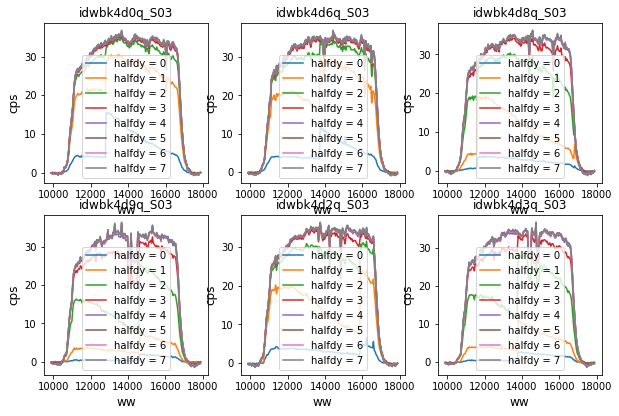

In [35]:
##########
# make mask
##########
for i,ii in enumerate(crcorrfile):
    saveprefix = '{0}_{1}'.format(crcorrfile[i].split('/')[-1].split('_')[0],sourcename)
    savefolder = saveprefix
    plotformat = 'pdf'
    overwrite = False
    containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
    sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
    gfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
    gdata = fits.open(gfile[0])[gfile[1]]
    ny,nx = gdata.shape
    trace = './{0}/{1}_trace.csv'.format(sfolder,sprefix)
    trace = pd.read_csv(trace)
    bbcorner = './{0}/{1}_bbcorner.csv'.format(sfolder,sprefix)
    bbcorner = pd.read_csv(bbcorner)
    tx = trace.xh + trace.xyref[0] - bbcorner.bb0x[0] 
    ty = trace.yh + trace.xyref[1] - bbcorner.bb0y[0]
    for j,jj in enumerate(halfdy):
        t = ObjectMask(nx,ny,tx,ty,halfdy[j],halfdy[j])
        t.compute()
        tmpcont = copy.deepcopy(containerobj)
        tmpcont.data['saveprefix'] += '_halfdy{0}'.format(halfdy[j])
        t.save(tmpcont)
#         plt.figure(),plt.imshow(t.mask,origin='lower')

##########
# Extraction
##########
for j,jj in enumerate(crcorrfile):
    for i,ii in enumerate(halfdy):
        saveprefix = '{0}_{1}'.format(crcorrfile[j].split('/')[-1].split('_')[0],sourcename)
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
        sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
        gfile = ('./{0}/{1}_sub.fits'.format(sfolder,sprefix),1)
        mfile = ('./{0}/{1}_halfdy{2}_mask.fits'.format(sfolder,sprefix,halfdy[i]),1)
        bbox = pd.read_csv('./{0}/{1}_bbox.csv'.format(sfolder,sprefix))
        trace = pd.read_csv('./{0}/{1}_trace.csv'.format(sfolder,sprefix))
        tbox = pd.read_csv('./{0}/{1}_tbox.csv'.format(sfolder,sprefix))
        instrument = 'HST-WFC3-IR-G102'
        ww = trace.ww.values
        xh = trace.xh.values
        cps = fits.open(gfile[0])[gfile[1]].data
        cps *= fits.open(mfile[0])[mfile[1]].data
        cps = np.nansum(cps,axis=0)[bbox.padxleft[0]:-bbox.padxright[0]]
        output = {'ww':ww,'cps':cps}
        string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
        pd.DataFrame(output).to_csv(string)
        print('Save {0}'.format(string))
        
##########
# show_cps
##########
fig = plt.figure(figsize=(10,10))
n = len(crcorrfile)
ncol = 3
nrow = int(n/ncol) + 1
for j,jj in enumerate(crcorrfile):
    ax = fig.add_subplot(nrow,ncol,j+1)
    for i,ii in enumerate(halfdy):
        saveprefix = '{0}_{1}'.format(crcorrfile[j].split('/')[-1].split('_')[0],sourcename)
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
        sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
        string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
        t = pd.read_csv(string)
        plt.plot(t.ww,t.cps,label='halfdy = {0}'.format(halfdy[i]))
    ax.legend()
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('cps',fontsize=12)
    ax.set_title('{0}'.format(sprefix),fontsize=12)



/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d0q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d6q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d8q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d9q_S03 already exists. To create a fresh folder, set overwrite = True
  warnings.warn(string)
/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/hstgrism/container.py:31: UserWarning: Folder idwbk4d2q_S03 already exis

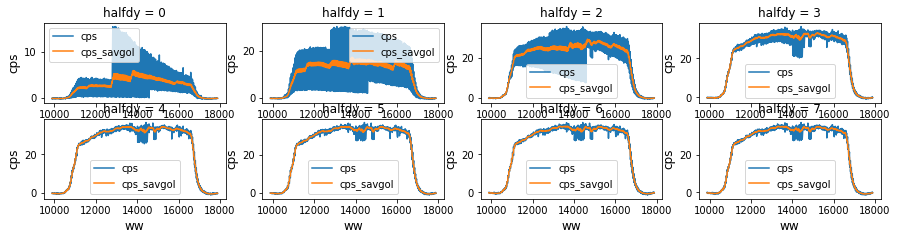

In [36]:
##########
# average
##########
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

window_length = len(crcorrfile) * 2 + 1
polyorder = 0

cpslist = {}
for i,ii in enumerate(halfdy):
    cpslist[halfdy[i]] = {'ww':None,'cps':None}
    for j,jj in enumerate(crcorrfile):
        saveprefix = '{0}_{1}'.format(crcorrfile[j].split('/')[-1].split('_')[0],sourcename)
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        containerobj = Container(saveprefix,savefolder,plotformat,overwrite)
        sfolder,sprefix = containerobj.data['savefolder'],containerobj.data['saveprefix']
        string = './{0}/{1}_halfdy{2}_cps.csv'.format(sfolder,sprefix,halfdy[i])
        if j==0:
            t = pd.read_csv(string)
        else:
            tt = pd.read_csv(string)
            t = pd.concat([t,tt])
    t.sort_values(by=['ww'],inplace=True)
    cpslist[halfdy[i]] = {'ww':t.ww.values.copy(),'cps':t.cps.values.copy()}
    
for i,ii in enumerate(cpslist):
    ww = cpslist[ii]['ww']
    cps = cpslist[ii]['cps']
    t = savgol_filter(cps,window_length=window_length,polyorder=polyorder)
    cpslist[ii]['cps_savgol'] = t.copy()
    
for i,ii in enumerate(cpslist):
    ww = cpslist[ii]['ww']
    cps_savgol = cpslist[ii]['cps_savgol']
    t = interp1d(ww,cps_savgol,kind='linear',bounds_error=False,fill_value=np.nan)
    cpslist[ii]['cps_model'] = copy.deepcopy(t)
    
fig = plt.figure(figsize=(15,5))
n = len(halfdy)
ncol = 4
nrow = int(n/ncol) + 1
for i,ii in enumerate(halfdy):
    ax = fig.add_subplot(nrow,ncol,i+1)
    ax.plot(cpslist[ii]['ww'],cpslist[ii]['cps'],label='cps')
    ax.plot(cpslist[ii]['ww'],cpslist[ii]['cps_savgol'],label='cps_savgol')
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('cps',fontsize=12)
    ax.set_title('halfdy = {0}'.format(ii),fontsize=12)
    ax.legend()
    

# 3. Compute aperture correction = drzblot / crcorr

In [37]:
drzlist = {}
for i,ii in enumerate(halfdy):
    string = './drzblot_{1}/drzblot_{1}_halfdy{0}_cps.csv'.format(halfdy[i],sourcename)
    t = pd.read_csv(string)
    ww,cps = t.ww.values.copy(),t.cps.values.copy()
    crcorr_model = cpslist[ii]['cps_model'](ww)
    drzlist[halfdy[i]] = {'ww':ww.copy(),'cps':cps.copy(),'crcorr_model':crcorr_model.copy()}


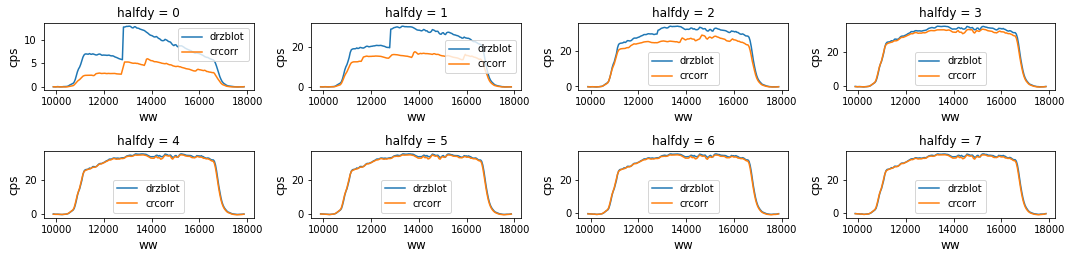

In [38]:
fig = plt.figure(figsize=(15,5))
n = len(halfdy)
ncol = 4
nrow = int(n/ncol) + 1
for i,ii in enumerate(halfdy):
    drz_ww,drz_cps = drzlist[ii]['ww'],drzlist[ii]['cps']
    crcorr_cps = drzlist[ii]['crcorr_model']
    ax = fig.add_subplot(nrow,ncol,i+1)
    ax.plot(drz_ww,drz_cps,label='drzblot')
    ax.plot(drz_ww,crcorr_cps,label='crcorr')
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('cps',fontsize=12)
    ax.set_title('halfdy = {0}'.format(ii),fontsize=12)
    ax.legend()
fig.tight_layout()


halfdy = 0, median = 1.162E+00
halfdy = 1, median = 6.813E-01
halfdy = 2, median = 1.834E-01
halfdy = 3, median = 4.892E-02
halfdy = 4, median = 1.469E-02
halfdy = 5, median = 1.391E-02
halfdy = 6, median = 1.453E-02
halfdy = 7, median = 1.325E-02


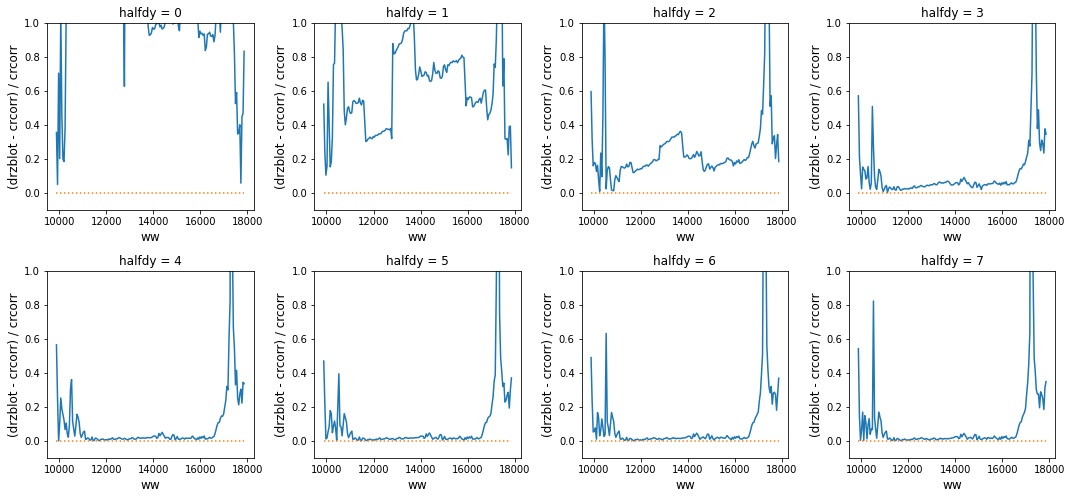

In [39]:
fig = plt.figure(figsize=(15,10))
n = len(halfdy)
ncol = 4
nrow = int(n/ncol) + 1
for i,ii in enumerate(halfdy):
    drz_ww,drz_cps = drzlist[ii]['ww'],drzlist[ii]['cps']
    crcorr_cps = drzlist[ii]['crcorr_model']
    ax = fig.add_subplot(nrow,ncol,i+1)
    t = np.abs((drz_cps - crcorr_cps)/crcorr_cps)
    ax.plot(drz_ww,t)
    ax.plot([drz_ww.min(),drz_ww.max()],[0.,0.],':')
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('(drzblot - crcorr) / crcorr',fontsize=12)
    ax.set_title('halfdy = {0}'.format(ii),fontsize=12)
    m = np.argwhere((drz_ww >= 11000.) & (drz_ww <= 16500.)).flatten()
    print('halfdy = {0}, median = {1:.3E}'.format(ii,np.median(t[m])))
    ax.set_ylim(-0.1,1.)
fig.tight_layout()


halfdy = 0, median = 2.162E+00
halfdy = 1, median = 1.681E+00
halfdy = 2, median = 1.183E+00
halfdy = 3, median = 1.049E+00
halfdy = 4, median = 1.014E+00
halfdy = 5, median = 1.014E+00
halfdy = 6, median = 1.014E+00
halfdy = 7, median = 1.013E+00


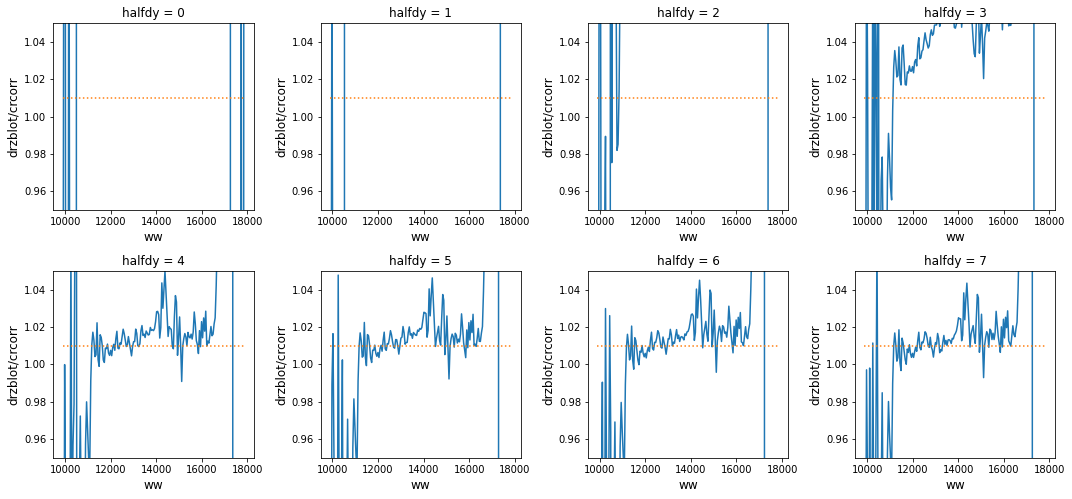

In [45]:
fig = plt.figure(figsize=(15,10))
n = len(halfdy)
ncol = 4
nrow = int(n/ncol) + 1
for i,ii in enumerate(halfdy):
    drz_ww,drz_cps = drzlist[ii]['ww'],drzlist[ii]['cps']
    crcorr_cps = drzlist[ii]['crcorr_model']
    ax = fig.add_subplot(nrow,ncol,i+1)
    t = drz_cps/crcorr_cps
    ax.plot(drz_ww,t)
    ax.plot([drz_ww.min(),drz_ww.max()],[1.01,1.01],':')
    ax.set_xlabel('ww',fontsize=12)
    ax.set_ylabel('drzblot/crcorr',fontsize=12)
    ax.set_title('halfdy = {0}'.format(ii),fontsize=12)
    ax.set_ylim(0.95,1.05)
    m = np.argwhere((drz_ww >= 11000.) & (drz_ww <= 16500.)).flatten()
    print('halfdy = {0}, median = {1:.3E}'.format(ii,np.median(t[m])))
fig.tight_layout()


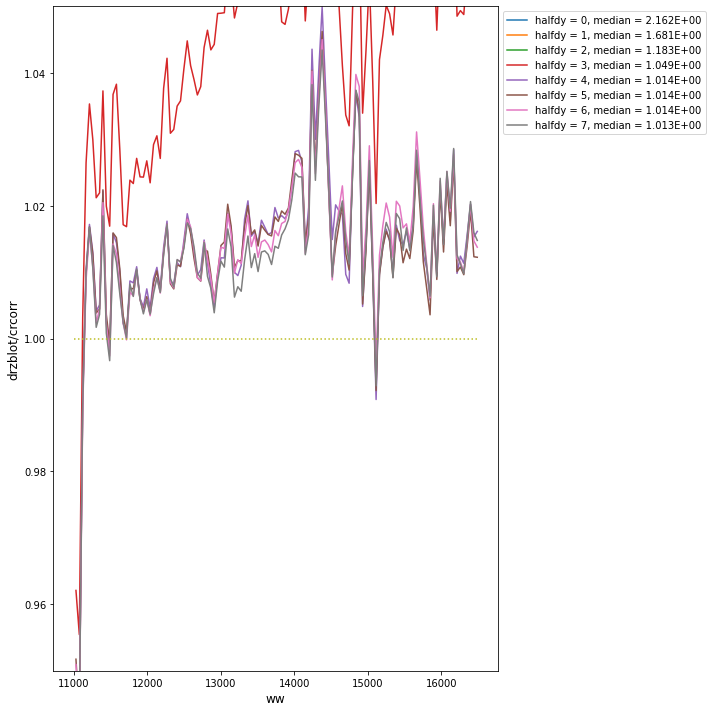

In [41]:
plt.figure(figsize=(10,10))
for i,ii in enumerate(halfdy):
    drz_ww,drz_cps = drzlist[ii]['ww'],drzlist[ii]['cps']
    crcorr_cps = drzlist[ii]['crcorr_model']
    m = np.argwhere((drz_ww >= 11000.) & (drz_ww <= 16500.)).flatten()
    t = drz_cps/crcorr_cps
    plt.plot(drz_ww[m],t[m],label='halfdy = {0}, median = {1:.3E}'.format(ii,np.median(t[m])))
    plt.xlabel('ww',fontsize=12)
plt.plot([11000.,16500.],[1.,1.],':')
plt.ylabel('drzblot/crcorr',fontsize=12)
plt.ylim(0.95,1.05)
plt.legend(bbox_to_anchor=(1., 1.))
plt.tight_layout()


# Summary
Setting halfdy >= 4 pixels would yield drzblot/crcorr < ~2% for S03.
